# 1 - Import Libraries

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDOneClassSVM
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# Add more classification lib here
from sklearn.metrics import classification_report, precision_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV

import pickle
import json
import warnings
warnings.filterwarnings('ignore')

# 2 - Loading Data

In [2]:
df = pd.read_csv('undersample_data_clean.csv', index_col=False)
df.head()

,Unnamed: 0,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,...,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn,monthly_charges_cat,tenure_year
0,1327,Female,No,No,No,1,No,No phone service,DSL,No,...,No,No,Month-to-month,Yes,Mailed check,25.15,25.15,No,Low Expense,1
1,1526,Female,No,Yes,Yes,35,Yes,Yes,No,No internet service,...,No internet service,No internet service,Month-to-month,Yes,Electronic check,25.75,882.55,No,Low Expense,3
2,6569,Female,No,No,Yes,10,Yes,Yes,DSL,Yes,...,No,Yes,One year,No,Credit card (automatic),73.55,693.30,No,Medium High Expense,1
3,3999,Male,No,Yes,Yes,72,Yes,No,No,No internet service,...,No internet service,No internet service,Two year,Yes,Credit card (automatic),19.80,1414.65,No,Low Expense,6
4,5989,Male,No,Yes,No,48,Yes,No,No,No internet service,...,No internet service,No internet service,Two year,Yes,Mailed check,20.05,1036.00,No,Low Expense,4


In [3]:
def exploreNumCol(df,  col):
    mean = df[col].mean()
    median = df[col].median()
    modus = df[col].mode().values[0]

    min = df[col].min()
    max = df[col].max()

    print(f'Mean {col} = {mean:.2f}')
    print(f'Median {col} = {median}')
    print(f'Modus {col} = {modus}')
    print(f'Min {col} = {min}')
    print(f'Max {col} = {max}')

    skew = df[col].skew()
    if skew < 0.5:
        print(f'Skewness {col} = {skew}, data distribution is normal')
    else:
        print(f'Skewness {col} = {skew}, data distribution is not normal')

In [4]:
numCol = ['tenure',	'monthly_charges',	'total_charges']
for nCol in numCol:
    exploreNumCol(df, nCol)
    print('')

Mean tenure = 29.50
Median tenure = 24.0
Modus tenure = 1
Min tenure = 1
Max tenure = 72
Skewness tenure = 0.39588057777071356, data distribution is normal

Mean monthly_charges = 66.90
Median monthly_charges = 73.85
Modus monthly_charges = 20.05
Min monthly_charges = 18.25
Max monthly_charges = 118.6
Skewness monthly_charges = -0.32718584371730813, data distribution is normal

Mean total_charges = 2137.32
Median total_charges = 1250.1
Modus total_charges = 19.9
Min total_charges = 18.8
Max total_charges = 8684.8
Skewness total_charges = 1.0700898918483348, data distribution is not normal



> Handling outlier sudah tak kerjakan di data_engineer --GILANG

In [5]:
def diagnostic_plots(df, variable):
    # Define figure size
    plt.figure(figsize=(16, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df, bins=30) if variable is None else sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df) if variable is None else sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

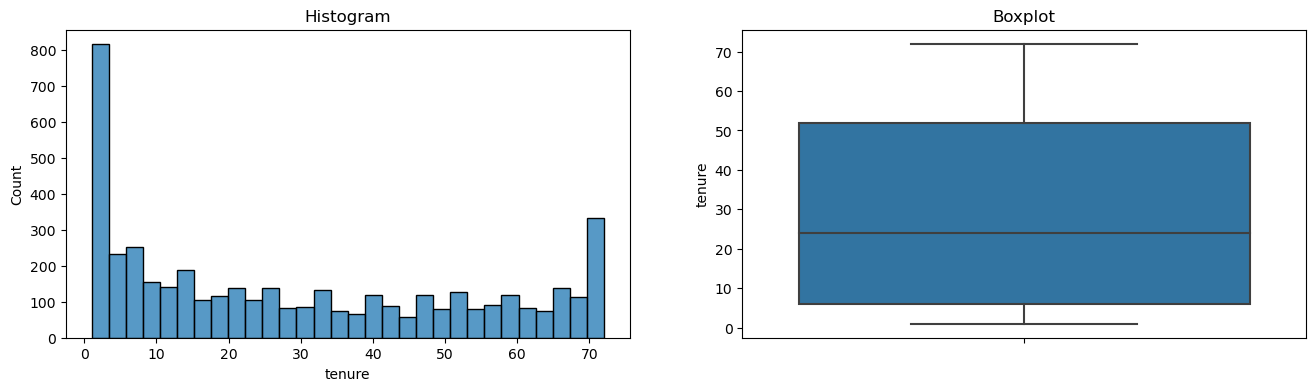

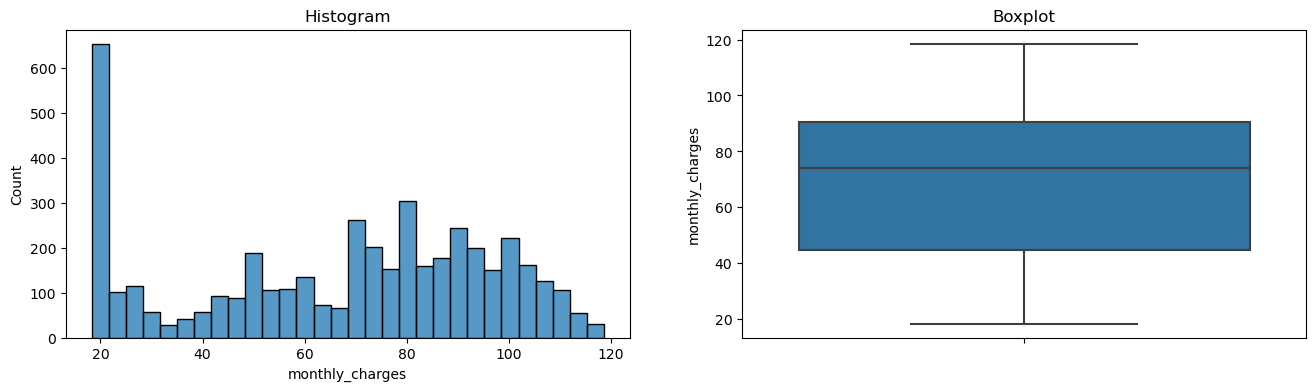

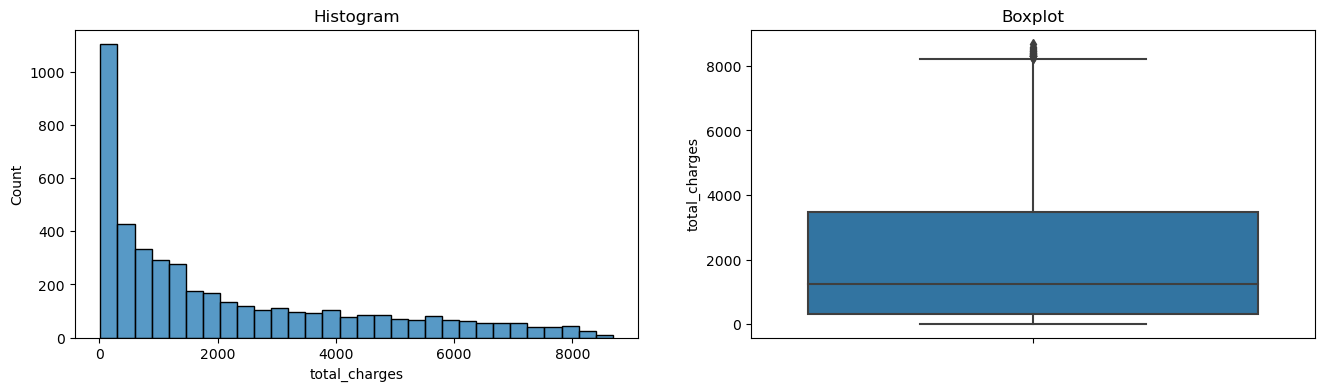

In [6]:
numCol = ['tenure',	'monthly_charges',	'total_charges']
for nCol in numCol:
    diagnostic_plots(df, nCol)

# 3 - Feature Selection

In [7]:
for x in df.columns:
    contingency_table4 = pd.crosstab(df[x],df['churn'])
    print(f'column {x} {stats.chi2_contingency(contingency_table4).pvalue}')

column Unnamed: 0 0.4929527393739349
column gender 0.3581415623596673
column senior_citizen 1.8521476472700925e-25
column partner 3.5778509656405413e-32
column dependents 2.1511582583192565e-36
column tenure 4.140829452618302e-129
column phone_service 0.41074520087377997
column multiple_lines 0.0331043292159368
column internet_service 2.1844118380528276e-128
column online_security 5.200826387714978e-153
column online_backup 7.848537444560684e-107
column device_protection 5.2994988001329886e-101
column tech_support 3.856825879570305e-145
column streaming_tv 1.857318096163576e-72
column streaming_movies 2.464076465658833e-73
column contract 3.07132364929811e-215
column paperless_billing 3.593967930250952e-46
column payment_method 4.684756307324047e-102
column monthly_charges 5.018174207658054e-11
column total_charges 0.27166956936014164
column churn 0.0
column monthly_charges_cat 1.0282731093629167e-62
column tenure_year 3.3865493938415696e-150


In [8]:
columns = ['senior_citizen','partner','dependents', 'internet_service',
        'online_security','online_backup','device_protection','tech_support',
        'streaming_tv', 'streaming_movies', 'contract',
        'paperless_billing', 'payment_method', 'monthly_charges', 'churn', 'tenure_year']
df = df.drop(columns=[col for col in df if col not in columns])
df.columns

Index(['senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'contract', 'paperless_billing',
       'payment_method', 'monthly_charges', 'churn', 'tenure_year'],
      dtype='object')

# 4 - Split Features

In [9]:
df["churn"]= df["churn"].map({"No": 0, "Yes": 1})

In [10]:
X = df.drop('churn', axis =  1)
y = df['churn']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=2)

print('Train Size :',X_train.shape)

print('Test Size :',X_test.shape)

X_train

Train Size : (3560, 15)
Test Size : (891, 15)


,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,tenure_year
3193,No,No,No,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,47.80,1
570,No,No,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Bank transfer (automatic),19.25,3
2216,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),19.45,6
2822,Yes,No,No,DSL,No,No,No,No,No,No,Month-to-month,No,Mailed check,44.95,1
2254,Yes,No,No,DSL,No,No,No,Yes,No,No,Month-to-month,No,Mailed check,49.20,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3335,Yes,No,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,71.00,1
1099,No,Yes,No,DSL,No,No,Yes,Yes,No,Yes,One year,Yes,Mailed check,69.55,4
2514,No,No,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,19.95,1
3606,No,No,No,Fiber optic,No,Yes,No,No,No,No,Month-to-month,No,Electronic check,74.95,1


# 5 - Split Columns

In [12]:
num = ['monthly_charges', 'tenure_year']
cat = ['senior_citizen', 'partner', 'dependents', 'internet_service', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 
       'contract', 'paperless_billing', 'payment_method']

In [13]:
X_train_num = X_train[num]
X_train_cat = X_train[cat]

X_test_num = X_test[num]
X_test_cat = X_test[cat]

In [14]:
df['monthly_charges'].skew()

-0.32718584371730813

In [15]:
df['tenure_year'].skew()

0.42050353311177596

# 6 - Feature Scaling

In [16]:
normal_transformer = Pipeline([
    ('minmax', MinMaxScaler())
])

# 7 - Feature Encoding

In [17]:
categorical_transformer = Pipeline([
    ('encoder', OneHotEncoder())
])

# 8 - Merge Data

In [18]:
preprocessor = ColumnTransformer(transformers=[
    ('normal', normal_transformer, num),
    ('cat', categorical_transformer, cat)
])

# 9 - Model Definition

In [19]:
pipe_logreg = Pipeline([('preprocessor',preprocessor),('classifier',LogisticRegression())])
pipe_knn = Pipeline([('preprocessor',preprocessor),('classifier',KNeighborsClassifier())])
pipe_svm = Pipeline([('preprocessor',preprocessor),('classifier',SVC())]) 
pipe_dt = Pipeline([('preprocessor',preprocessor),('classifier',DecisionTreeClassifier())])
pipe_rf = Pipeline([('preprocessor',preprocessor),('classifier',RandomForestClassifier())])
pipe_boost = Pipeline([('preprocessor',preprocessor),('classifier',AdaBoostClassifier(LogisticRegression()))])
pipe_gradient = Pipeline([('preprocessor',preprocessor),('classifier',GradientBoostingClassifier())])
pipe_boost2 = Pipeline([('preprocessor',preprocessor),('classifier',AdaBoostClassifier(RandomForestClassifier(criterion='gini',
                                                                                                              max_depth=1,
                                                                                                              max_features='sqrt',
                                                                                                              min_samples_leaf=1,
                                                                                                              min_samples_split=0.5,
                                                                                                              n_estimators=100,
                                                                                                              random_state=10)))])

In [20]:
{'classifier__C': 0.25,
 'classifier__fit_intercept': False,
 'classifier__max_iter': 50,
 'classifier__multi_class': 'multinomial',
 'classifier__penalty': None,
 'classifier__random_state': 10,
 'classifier__solver': 'sag',
 'classifier__tol': 1e-05}

{'classifier__C': 0.25,
 'classifier__fit_intercept': False,
 'classifier__max_iter': 50,
 'classifier__multi_class': 'multinomial',
 'classifier__penalty': None,
 'classifier__random_state': 10,
 'classifier__solver': 'sag',
 'classifier__tol': 1e-05}

# 10 - Model Training

In [21]:
pipe_logreg.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('skewed',
                                                  Pipeline(steps=[('minmax',
                                                                   MinMaxScaler())]),
                                                  ['monthly_charges',
                                                   'tenure_year']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['senior_citizen', 'partner',
                                                   'dependents',
                                                   'internet_service',
                                                   'online_security',
                                                   'online_backup',
                                                   'device_protection',
                                                   'tech_support',
                                                   'streaming_tv',
                                                   'streaming_movies',
                                                   'contract',
                                                   'paperless_billing',
                                                   'payment_method'])])),
                ('classifier', LogisticRegression())])

In [22]:
pipe_knn.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('skewed',
                                                  Pipeline(steps=[('minmax',
                                                                   MinMaxScaler())]),
                                                  ['monthly_charges',
                                                   'tenure_year']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['senior_citizen', 'partner',
                                                   'dependents',
                                                   'internet_service',
                                                   'online_security',
                                                   'online_backup',
                                                   'device_protection',
                                                   'tech_support',
                                                   'streaming_tv',
                                                   'streaming_movies',
                                                   'contract',
                                                   'paperless_billing',
                                                   'payment_method'])])),
                ('classifier', KNeighborsClassifier())])

In [23]:
pipe_svm.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('skewed',
                                                  Pipeline(steps=[('minmax',
                                                                   MinMaxScaler())]),
                                                  ['monthly_charges',
                                                   'tenure_year']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['senior_citizen', 'partner',
                                                   'dependents',
                                                   'internet_service',
                                                   'online_security',
                                                   'online_backup',
                                                   'device_protection',
                                                   'tech_support',
                                                   'streaming_tv',
                                                   'streaming_movies',
                                                   'contract',
                                                   'paperless_billing',
                                                   'payment_method'])])),
                ('classifier', SVC())])

In [24]:
pipe_dt.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('skewed',
                                                  Pipeline(steps=[('minmax',
                                                                   MinMaxScaler())]),
                                                  ['monthly_charges',
                                                   'tenure_year']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['senior_citizen', 'partner',
                                                   'dependents',
                                                   'internet_service',
                                                   'online_security',
                                                   'online_backup',
                                                   'device_protection',
                                                   'tech_support',
                                                   'streaming_tv',
                                                   'streaming_movies',
                                                   'contract',
                                                   'paperless_billing',
                                                   'payment_method'])])),
                ('classifier', DecisionTreeClassifier())])

In [25]:
pipe_rf.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('skewed',
                                                  Pipeline(steps=[('minmax',
                                                                   MinMaxScaler())]),
                                                  ['monthly_charges',
                                                   'tenure_year']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['senior_citizen', 'partner',
                                                   'dependents',
                                                   'internet_service',
                                                   'online_security',
                                                   'online_backup',
                                                   'device_protection',
                                                   'tech_support',
                                                   'streaming_tv',
                                                   'streaming_movies',
                                                   'contract',
                                                   'paperless_billing',
                                                   'payment_method'])])),
                ('classifier', RandomForestClassifier())])

In [26]:
pipe_boost.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('skewed',
                                                  Pipeline(steps=[('minmax',
                                                                   MinMaxScaler())]),
                                                  ['monthly_charges',
                                                   'tenure_year']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['senior_citizen', 'partner',
                                                   'dependents',
                                                   'internet_service',
                                                   'online_security',
                                                   'online_backup',
                                                   'device_protection',
                                                   'tech_support',
                                                   'streaming_tv',
                                                   'streaming_movies',
                                                   'contract',
                                                   'paperless_billing',
                                                   'payment_method'])])),
                ('classifier',
                 AdaBoostClassifier(estimator=LogisticRegression()))])

In [27]:
pipe_gradient.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('skewed',
                                                  Pipeline(steps=[('minmax',
                                                                   MinMaxScaler())]),
                                                  ['monthly_charges',
                                                   'tenure_year']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['senior_citizen', 'partner',
                                                   'dependents',
                                                   'internet_service',
                                                   'online_security',
                                                   'online_backup',
                                                   'device_protection',
                                                   'tech_support',
                                                   'streaming_tv',
                                                   'streaming_movies',
                                                   'contract',
                                                   'paperless_billing',
                                                   'payment_method'])])),
                ('classifier', GradientBoostingClassifier())])

In [28]:
pipe_boost2.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('skewed',
                                                  Pipeline(steps=[('minmax',
                                                                   MinMaxScaler())]),
                                                  ['monthly_charges',
                                                   'tenure_year']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['senior_citizen', 'partner',
                                                   'dependents',
                                                   'internet_service',
                                                   'online_security',
                                                   'online_backup',
                                                   'device_protection',
                                                   'tech_support',
                                                   'streaming_tv',
                                                   'streaming_movies',
                                                   'contract',
                                                   'paperless_billing',
                                                   'payment_method'])])),
                ('classifier',
                 AdaBoostClassifier(estimator=RandomForestClassifier(max_depth=1,
                                                                     min_samples_split=0.5,
                                                                     random_state=10)))])

# 11 - Model Evaluation

In [29]:
def performance_check(clf, X, y):
  y_pred = clf.predict(X)

  return precision_score(y, y_pred)

## 11.1 - Logistic Regression Evaluation

In [30]:
y_pred_train_logreg = pipe_logreg.predict(X_train)
y_pred_test_logreg = pipe_logreg.predict(X_test)

y_pred_train_logreg

array([1, 0, 0, ..., 0, 1, 0], dtype=int64)

In [31]:
print('Precision - Train : ', performance_check(pipe_logreg, X_train, y_train))
print('Precision - Test  : ', performance_check(pipe_logreg, X_test, y_test))

Precision - Train :  0.7257653061224489
Precision - Test  :  0.6828571428571428


## 11.2 - KNN Evaluation

In [32]:
y_pred_train_knn = pipe_knn.predict(X_train)
y_pred_test_knn = pipe_knn.predict(X_test)

y_pred_train_knn

array([1, 0, 0, ..., 0, 1, 0], dtype=int64)

In [33]:
print('Precision - Train : ', performance_check(pipe_knn, X_train, y_train))
print('Precision - Test  : ', performance_check(pipe_knn, X_test, y_test))

Precision - Train :  0.7617574257425742
Precision - Test  :  0.6240786240786241


## 11.3 - SVM Evaluation

In [34]:
y_pred_train_svm = pipe_svm.predict(X_train)
y_pred_test_svm = pipe_svm.predict(X_test)

y_pred_train_svm

array([1, 0, 0, ..., 0, 1, 0], dtype=int64)

In [35]:
print('Precision - Train : ', performance_check(pipe_svm, X_train, y_train))
print('Precision - Test  : ', performance_check(pipe_svm, X_test, y_test))

Precision - Train :  0.7317073170731707
Precision - Test  :  0.6775067750677507


## 11.4 - DecisionTree Evaluation

In [36]:
y_pred_train_dt = pipe_svm.predict(X_train)
y_pred_test_dt = pipe_svm.predict(X_test)

y_pred_train_dt

array([1, 0, 0, ..., 0, 1, 0], dtype=int64)

In [37]:
print('Precision - Train : ', performance_check(pipe_dt, X_train, y_train))
print('Precision - Test  : ', performance_check(pipe_dt, X_test, y_test))

Precision - Train :  0.9986648865153538
Precision - Test  :  0.5714285714285714


## 11.5 - RandomForest Evaluation

In [38]:
y_pred_train_rf = pipe_svm.predict(X_train)
y_pred_test_rf = pipe_svm.predict(X_test)

y_pred_train_rf

array([1, 0, 0, ..., 0, 1, 0], dtype=int64)

In [39]:
print('Precision - Train : ', performance_check(pipe_rf, X_train, y_train))
print('Precision - Test  : ', performance_check(pipe_rf, X_test, y_test))

Precision - Train :  0.9882352941176471
Precision - Test  :  0.6408045977011494


## 11.6 - AdaBoost Evaluation

In [40]:
y_pred_train_boost = pipe_boost.predict(X_train)
y_pred_test_boost = pipe_boost.predict(X_test)

y_pred_train_boost

array([1, 0, 0, ..., 0, 1, 0], dtype=int64)

In [41]:
print('Precision - Train : ', performance_check(pipe_boost, X_train, y_train))
print('Precision - Test  : ', performance_check(pipe_boost, X_test, y_test))

Precision - Train :  0.7145510835913312
Precision - Test  :  0.6793478260869565


## 11.7 -  GradientBoosting Evaluation

In [42]:
y_pred_train_gradient = pipe_gradient.predict(X_train)
y_pred_test_gradient = pipe_gradient.predict(X_test)

y_pred_train_gradient

array([1, 0, 0, ..., 0, 1, 0], dtype=int64)

In [43]:
print('Precision - Train : ', performance_check(pipe_gradient, X_train, y_train))
print('Precision - Test  : ', performance_check(pipe_gradient, X_test, y_test))

Precision - Train :  0.7498371335504886
Precision - Test  :  0.6896551724137931


## 11.8 -  AdaBoost RandomForest Evaluation

In [44]:
y_pred_train_boost2 = pipe_boost2.predict(X_train)
y_pred_test_boost2 = pipe_boost2.predict(X_test)

y_pred_train_boost2

array([1, 0, 0, ..., 0, 1, 0], dtype=int64)

In [45]:
print('Precision - Train : ', performance_check(pipe_boost2, X_train, y_train))
print('Precision - Test  : ', performance_check(pipe_boost2, X_test, y_test))

Precision - Train :  0.7185741088180112
Precision - Test  :  0.6885245901639344


# 12 -  Model Improvement

## 12.1 - Logistic Regression Grid Search

In [46]:
penalty = ['l2','elasticnet',None]
tol = [0.0001, 0.0001]
C = [0.25, 0.5, 0.75]
fit_intercept = [True,False]
random_state = [10]
solver = ['lbfgs','liblinear','sag']
max_iter = [25,50,75]
multi_class = ['ovr','auto','multinomial']

logreg_search_params = {'classifier__penalty':penalty,'classifier__tol':tol,
                        'classifier__C':C,'classifier__fit_intercept':fit_intercept,
                        'classifier__random_state':random_state,'classifier__solver':solver,
                        'classifier__max_iter':max_iter,'classifier__multi_class':multi_class}
logreg_search_params

{'classifier__penalty': ['l2', 'elasticnet', None],
 'classifier__tol': [0.0001, 0.0001],
 'classifier__C': [0.25, 0.5, 0.75],
 'classifier__fit_intercept': [True, False],
 'classifier__random_state': [10],
 'classifier__solver': ['lbfgs', 'liblinear', 'sag'],
 'classifier__max_iter': [25, 50, 75],
 'classifier__multi_class': ['ovr', 'auto', 'multinomial']}

In [47]:
logreg_gridcv = GridSearchCV(estimator=pipe_logreg,param_grid=logreg_search_params,
                                 cv=5,
                                 n_jobs=-1,
                                 scoring='precision')
logreg_gridcv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('skewed',
                                                                         Pipeline(steps=[('minmax',
                                                                                          MinMaxScaler())]),
                                                                         ['monthly_charges',
                                                                          'tenure_year']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder())]),
                                                                         ['senior_citizen',
                                                                          'partner',
                                                                          'dependents',
                                                                          'internet_service',
                                                                          'online_security',
                                                                          'online_backup',
                                                                          'device_protection',
                                                                          't...
             param_grid={'classifier__C': [0.25, 0.5, 0.75],
                         'classifier__fit_intercept': [True, False],
                         'classifier__max_iter': [25, 50, 75],
                         'classifier__multi_class': ['ovr', 'auto',
                                                     'multinomial'],
                         'classifier__penalty': ['l2', 'elasticnet', None],
                         'classifier__random_state': [10],
                         'classifier__solver': ['lbfgs', 'liblinear', 'sag'],
                         'classifier__tol': [0.0001, 0.0001]},
             scoring='precision')

In [48]:
logreg_gridcv.best_params_

{'classifier__C': 0.25,
 'classifier__fit_intercept': False,
 'classifier__max_iter': 50,
 'classifier__multi_class': 'multinomial',
 'classifier__penalty': None,
 'classifier__random_state': 10,
 'classifier__solver': 'sag',
 'classifier__tol': 0.0001}

In [49]:
logreg_gridcv_best = logreg_gridcv.best_estimator_

In [50]:
y_pred_test_logreg_final = logreg_gridcv_best.predict(X_test)
y_pred_train_logreg_final = logreg_gridcv_best.predict(X_train)
print('Train : ', performance_check(logreg_gridcv_best, X_train, y_train))
print('Test  : ', performance_check(logreg_gridcv_best, X_test, y_test))

Train :  0.7149234693877551
Test  :  0.6713483146067416


In [51]:
print(accuracy_score(y_pred_test_logreg, y_test))

0.7564534231200898


In [52]:
precision_logreg_cross_val = cross_val_score(logreg_gridcv_best,
                                     X_train,
                                     y_train,
                                     cv=5,
                                     scoring="precision",
                                     error_score='raise')

In [53]:
print('Precision Score - All - Cross Validation  : ', precision_logreg_cross_val)
print('Precision - Mean - Cross Validation : ', precision_logreg_cross_val.mean())
print('Precision - Std - Cross Validation  : ', precision_logreg_cross_val.std())
print('Precision Score - Range of Test-Set       : ', (precision_logreg_cross_val.mean()-precision_logreg_cross_val.std()) , '-', (precision_logreg_cross_val.mean()+precision_logreg_cross_val.std()))

Precision Score - All - Cross Validation  :  [0.81151832 0.74087591 0.74712644 0.68238994 0.73559322]
Precision - Mean - Cross Validation :  0.74350076624872
Precision - Std - Cross Validation  :  0.04109376183868838
Precision Score - Range of Test-Set       :  0.7024070044100316 - 0.7845945280874084


## 12.2 -  SVM Gridsearch

In [54]:
C = [0.25,0.5,0.75]
kernel = ['linear','rbf','poly']
degree = [1,2]
gamma = ['scale','auto']
break_ties = [False]
max_iter = [-1]
cache_size = [7,8,9,10]
decision_function_shape = ['ovo','ovr']
random_state = [10]

svm_search_params = {'classifier__C' : C, 'classifier__kernel' : kernel, 'classifier__degree' : degree, 'classifier__gamma' : gamma, 'classifier__break_ties' : break_ties,
                       'classifier__max_iter' : max_iter, 'classifier__cache_size' : cache_size, 'classifier__decision_function_shape' : decision_function_shape, 'classifier__random_state' : random_state}
svm_search_params

{'classifier__C': [0.25, 0.5, 0.75],
 'classifier__kernel': ['linear', 'rbf', 'poly'],
 'classifier__degree': [1, 2],
 'classifier__gamma': ['scale', 'auto'],
 'classifier__break_ties': [False],
 'classifier__max_iter': [-1],
 'classifier__cache_size': [7, 8, 9, 10],
 'classifier__decision_function_shape': ['ovo', 'ovr'],
 'classifier__random_state': [10]}

In [55]:
svm_gridcv = GridSearchCV(estimator=pipe_svm,param_grid=svm_search_params,
                                 cv=5,
                                 n_jobs=-1,
                                 scoring='precision')
svm_gridcv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('skewed',
                                                                         Pipeline(steps=[('minmax',
                                                                                          MinMaxScaler())]),
                                                                         ['monthly_charges',
                                                                          'tenure_year']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder())]),
                                                                         ['senior_citizen',
                                                                          'partner',
                                                                          'dependents',
                                                                          'internet_service',
                                                                          'online_security',
                                                                          'online_backup',
                                                                          'device_protection',
                                                                          't...
             param_grid={'classifier__C': [0.25, 0.5, 0.75],
                         'classifier__break_ties': [False],
                         'classifier__cache_size': [7, 8, 9, 10],
                         'classifier__decision_function_shape': ['ovo', 'ovr'],
                         'classifier__degree': [1, 2],
                         'classifier__gamma': ['scale', 'auto'],
                         'classifier__kernel': ['linear', 'rbf', 'poly'],
                         'classifier__max_iter': [-1],
                         'classifier__random_state': [10]},
             scoring='precision')

In [56]:
svm_gridcv.best_params_

{'classifier__C': 0.25,
 'classifier__break_ties': False,
 'classifier__cache_size': 7,
 'classifier__decision_function_shape': 'ovo',
 'classifier__degree': 2,
 'classifier__gamma': 'auto',
 'classifier__kernel': 'poly',
 'classifier__max_iter': -1,
 'classifier__random_state': 10}

In [57]:
svm_gridcv_best = svm_gridcv.best_estimator_

In [58]:
y_pred_test_svm_final = svm_gridcv_best.predict(X_test)
y_pred_train_svm_final = svm_gridcv_best.predict(X_train)
print('Train : ', performance_check(svm_gridcv_best, X_train, y_train))
print('Test  : ', performance_check(svm_gridcv_best, X_test, y_test))

Train :  0.7032374100719424
Test  :  0.6614583333333334


In [59]:
print(accuracy_score(y_pred_test_svm, y_test))

0.7598204264870931


In [60]:
precision_svm_cross_val = cross_val_score(svm_gridcv_best,
                                     X_train,
                                     y_train,
                                     cv=5,
                                     scoring="precision",
                                     error_score='raise')

In [61]:
print('Precision Score - All - Cross Validation  : ', precision_svm_cross_val)
print('Precision - Mean - Cross Validation : ', precision_svm_cross_val.mean())
print('Precision - Std - Cross Validation  : ', precision_svm_cross_val.std())
print('Precision Score - Range of Test-Set       : ', (precision_svm_cross_val.mean()-precision_svm_cross_val.std()) , '-', (precision_svm_cross_val.mean()+precision_svm_cross_val.std()))

Precision Score - All - Cross Validation  :  [0.70996979 0.7027027  0.72402597 0.67346939 0.68604651]
Precision - Mean - Cross Validation :  0.6992428729262647
Precision - Std - Cross Validation  :  0.017774452057560706
Precision Score - Range of Test-Set       :  0.6814684208687041 - 0.7170173249838254


## 12.3 - RandomForest Grid Search

In [62]:
n_estimators = [100,]
criterion = ['gini']
max_depth = [1,2,3,None]
min_samples_split = [0.5,2]
min_samples_leaf = [0.5,1]
max_features = ['sqrt','log2',None]
random_state = [10]



rf_search_params = {'classifier__n_estimators':n_estimators,
                    'classifier__criterion':criterion,
                    'classifier__max_depth':max_depth,
                    'classifier__min_samples_split':min_samples_split,
                    'classifier__min_samples_leaf':min_samples_leaf,
                    'classifier__max_features':max_features,
                    'classifier__random_state':random_state}
rf_search_params

{'classifier__n_estimators': [100],
 'classifier__criterion': ['gini'],
 'classifier__max_depth': [1, 2, 3, None],
 'classifier__min_samples_split': [0.5, 2],
 'classifier__min_samples_leaf': [0.5, 1],
 'classifier__max_features': ['sqrt', 'log2', None],
 'classifier__random_state': [10]}

In [63]:
rf_gridcv = GridSearchCV(estimator=pipe_rf,param_grid=rf_search_params,
                                 cv=5,
                                 n_jobs=-1,
                                 scoring='precision')
rf_gridcv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('skewed',
                                                                         Pipeline(steps=[('minmax',
                                                                                          MinMaxScaler())]),
                                                                         ['monthly_charges',
                                                                          'tenure_year']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder())]),
                                                                         ['senior_citizen',
                                                                          'partner',
                                                                          'dependents',
                                                                          'internet_service',
                                                                          'online_security',
                                                                          'online_backup',
                                                                          'device_protection',
                                                                          't...
                                                                          'payment_method'])])),
                                       ('classifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__criterion': ['gini'],
                         'classifier__max_depth': [1, 2, 3, None],
                         'classifier__max_features': ['sqrt', 'log2', None],
                         'classifier__min_samples_leaf': [0.5, 1],
                         'classifier__min_samples_split': [0.5, 2],
                         'classifier__n_estimators': [100],
                         'classifier__random_state': [10]},
             scoring='precision')

In [64]:
rf_gridcv.best_params_

{'classifier__criterion': 'gini',
 'classifier__max_depth': 1,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 0.5,
 'classifier__n_estimators': 100,
 'classifier__random_state': 10}

In [65]:
rf_gridcv_best = rf_gridcv.best_estimator_

In [66]:
y_pred_test_svm_final = rf_gridcv_best.predict(X_test)
y_pred_train_svm_final = rf_gridcv_best.predict(X_train)
print('Train : ', performance_check(rf_gridcv_best, X_train, y_train))
print('Test  : ', performance_check(rf_gridcv_best, X_test, y_test))

Train :  0.7350246652572234
Test  :  0.6820987654320988


In [67]:
print(accuracy_score(y_pred_test_rf, y_test))

0.7598204264870931


In [68]:
precision_rf_cross_val = cross_val_score(rf_gridcv_best,
                                     X_train,
                                     y_train,
                                     cv=5,
                                     scoring="precision",
                                     error_score='raise')

In [69]:
print('Precision Score - All - Cross Validation  : ', precision_rf_cross_val)
print('Precision - Mean - Cross Validation : ', precision_rf_cross_val.mean())
print('Precision - Std - Cross Validation  : ', precision_rf_cross_val.std())
print('Precision Score - Range of Test-Set       : ', (precision_rf_cross_val.mean()-precision_rf_cross_val.std()) , '-', (precision_rf_cross_val.mean()+precision_rf_cross_val.std()))

Precision Score - All - Cross Validation  :  [0.77131783 0.74829932 0.75       0.6852459  0.73809524]
Precision - Mean - Cross Validation :  0.7385916577839675
Precision - Std - Cross Validation  :  0.028779879833248857
Precision Score - Range of Test-Set       :  0.7098117779507187 - 0.7673715376172163


## 12.4 - AdaBoost Grid Search

In [70]:
n_estimators = [1]
learning_rate = [0.001, 0.01, 0.1]
algorithm = ['SAMME','SAMME.R']
random_state = [10]

boost_search_params = {'classifier__n_estimators':n_estimators,'classifier__learning_rate':learning_rate,
                       'classifier__algorithm':algorithm,'classifier__random_state':random_state}
boost_search_params

{'classifier__n_estimators': [1],
 'classifier__learning_rate': [0.001, 0.01, 0.1],
 'classifier__algorithm': ['SAMME', 'SAMME.R'],
 'classifier__random_state': [10]}

In [71]:
boost_gridcv = GridSearchCV(estimator=pipe_boost,param_grid=boost_search_params,
                                 cv=5,
                                 n_jobs=-1,
                                 scoring='precision')
boost_gridcv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('skewed',
                                                                         Pipeline(steps=[('minmax',
                                                                                          MinMaxScaler())]),
                                                                         ['monthly_charges',
                                                                          'tenure_year']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder())]),
                                                                         ['senior_citizen',
                                                                          'partner',
                                                                          'dependents',
                                                                          'internet_service',
                                                                          'online_security',
                                                                          'online_backup',
                                                                          'device_protection',
                                                                          't...
                                                                          'streaming_tv',
                                                                          'streaming_movies',
                                                                          'contract',
                                                                          'paperless_billing',
                                                                          'payment_method'])])),
                                       ('classifier',
                                        AdaBoostClassifier(estimator=LogisticRegression()))]),
             n_jobs=-1,
             param_grid={'classifier__algorithm': ['SAMME', 'SAMME.R'],
                         'classifier__learning_rate': [0.001, 0.01, 0.1],
                         'classifier__n_estimators': [1],
                         'classifier__random_state': [10]},
             scoring='precision')

In [72]:
boost_gridcv.best_params_

{'classifier__algorithm': 'SAMME',
 'classifier__learning_rate': 0.001,
 'classifier__n_estimators': 1,
 'classifier__random_state': 10}

In [73]:
boost_gridcv_best = boost_gridcv.best_estimator_

In [74]:
y_pred_train_boost = boost_gridcv.predict(X_train)
y_pred_test_boost = boost_gridcv.predict(X_test)
print('Precision - Train : ', performance_check(boost_gridcv_best, X_train, y_train))
print('Precision - Test  : ', performance_check(boost_gridcv_best, X_test, y_test))

Precision - Train :  0.7952522255192879
Precision - Test  :  0.828125


In [75]:
print(accuracy_score(y_pred_test_boost, y_test))

0.7070707070707071


In [76]:
precision_boost_cross_val = cross_val_score(boost_gridcv_best,
                                     X_train,
                                     y_train,
                                     cv=5,
                                     scoring="precision",
                                     error_score='raise')

In [77]:
print('Precision Score - All - Cross Validation  : ', precision_boost_cross_val)
print('Precision - Mean - Cross Validation : ', precision_boost_cross_val.mean())
print('Precision - Std - Cross Validation  : ', precision_boost_cross_val.std())
print('Precision Score - Range of Test-Set       : ', (precision_boost_cross_val.mean()-precision_boost_cross_val.std()) , '-', (precision_boost_cross_val.mean()+precision_boost_cross_val.std()))

Precision Score - All - Cross Validation  :  [0.83216783 0.8013245  0.78813559 0.74626866 0.796875  ]
Precision - Mean - Cross Validation :  0.7929543170831694
Precision - Std - Cross Validation  :  0.02766189625050376
Precision Score - Range of Test-Set       :  0.7652924208326657 - 0.8206162133336732


## 12.5 - GradientBoosting Grid Search

In [78]:
loss = ['log_loss','exponential']
subsample = [0.5, 1]
n_estimators = [100]
learning_rate = [0.1]
criterion = ['friedman_mse','squared_error']
min_samples_split = [2]
min_samples_leaf = [1]
max_depth = [3]
random_state = [21]

gradient_search_params = {'classifier__loss':loss,
                          'classifier__subsample':subsample,
                          'classifier__criterion':criterion,
                          'classifier__min_samples_split':min_samples_split,
                          'classifier__min_samples_leaf':min_samples_leaf,
                          'classifier__max_depth':max_depth,
                          'classifier__n_estimators':n_estimators,
                          'classifier__learning_rate':learning_rate,
                          'classifier__random_state':random_state}
gradient_search_params

{'classifier__loss': ['log_loss', 'exponential'],
 'classifier__subsample': [0.5, 1],
 'classifier__criterion': ['friedman_mse', 'squared_error'],
 'classifier__min_samples_split': [2],
 'classifier__min_samples_leaf': [1],
 'classifier__max_depth': [3],
 'classifier__n_estimators': [100],
 'classifier__learning_rate': [0.1],
 'classifier__random_state': [21]}

In [79]:
gradient_gridcv = GridSearchCV(estimator=pipe_gradient,param_grid=gradient_search_params,
                                 cv=3,
                                 n_jobs=-1,
                                 scoring='precision')
gradient_gridcv.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('skewed',
                                                                         Pipeline(steps=[('minmax',
                                                                                          MinMaxScaler())]),
                                                                         ['monthly_charges',
                                                                          'tenure_year']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder())]),
                                                                         ['senior_citizen',
                                                                          'partner',
                                                                          'dependents',
                                                                          'internet_service',
                                                                          'online_security',
                                                                          'online_backup',
                                                                          'device_protection',
                                                                          't...
             param_grid={'classifier__criterion': ['friedman_mse',
                                                   'squared_error'],
                         'classifier__learning_rate': [0.1],
                         'classifier__loss': ['log_loss', 'exponential'],
                         'classifier__max_depth': [3],
                         'classifier__min_samples_leaf': [1],
                         'classifier__min_samples_split': [2],
                         'classifier__n_estimators': [100],
                         'classifier__random_state': [21],
                         'classifier__subsample': [0.5, 1]},
             scoring='precision')

In [80]:
gradient_gridcv.best_params_

{'classifier__criterion': 'friedman_mse',
 'classifier__learning_rate': 0.1,
 'classifier__loss': 'log_loss',
 'classifier__max_depth': 3,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 2,
 'classifier__n_estimators': 100,
 'classifier__random_state': 21,
 'classifier__subsample': 1}

In [81]:
gradient_gridcv_best = gradient_gridcv.best_estimator_

In [82]:
y_pred_train_gradient = gradient_gridcv_best.predict(X_train)
y_pred_test_gradient = gradient_gridcv_best.predict(X_test)
y_pred_train_gradient
print('Precision - Train : ', performance_check(gradient_gridcv_best, X_train, y_train))
print('Precision - Test  : ', performance_check(gradient_gridcv_best, X_test, y_test))

Precision - Train :  0.7498371335504886
Precision - Test  :  0.6905444126074498


In [83]:
print(accuracy_score(y_pred_test_gradient, y_test))

0.7620650953984287


In [84]:
precision_gradient_cross_val = cross_val_score(gradient_gridcv_best,
                                     X_train,
                                     y_train,
                                     cv=5,
                                     scoring="precision",
                                     error_score='raise')

In [85]:
print('Precision Score - All - Cross Validation  : ', precision_gradient_cross_val)
print('Precision - Mean - Cross Validation : ', precision_gradient_cross_val.mean())
print('Precision - Std - Cross Validation  : ', precision_gradient_cross_val.std())
print('Precision Score - Range of Test-Set       : ', (precision_gradient_cross_val.mean()-precision_gradient_cross_val.std()) , '-', (precision_gradient_cross_val.mean()+precision_gradient_cross_val.std()))

Precision Score - All - Cross Validation  :  [0.73178808 0.72204473 0.73010381 0.69648562 0.6993865 ]
Precision - Mean - Cross Validation :  0.7159617480407513
Precision - Std - Cross Validation  :  0.015109807537953168
Precision Score - Range of Test-Set       :  0.7008519405027981 - 0.7310715555787045


## 12.6 Random Forest AdaBoost Grid Search

In [86]:
n_estimators = [1,50,100]
learning_rate = [0.001, 0.01]
algorithm = ['SAMME','SAMME.R']
random_state = [10]

boost2_search_params = {'classifier__n_estimators':n_estimators,'classifier__learning_rate':learning_rate,
                       'classifier__algorithm':algorithm,'classifier__random_state':random_state}
boost2_search_params

{'classifier__n_estimators': [1, 50, 100],
 'classifier__learning_rate': [0.001, 0.01],
 'classifier__algorithm': ['SAMME', 'SAMME.R'],
 'classifier__random_state': [10]}

In [87]:
boost2_gridcv = GridSearchCV(estimator=pipe_boost2,param_grid=boost2_search_params,
                                 cv=5,
                                 n_jobs=-1,
                                 scoring='precision')
boost2_gridcv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('skewed',
                                                                         Pipeline(steps=[('minmax',
                                                                                          MinMaxScaler())]),
                                                                         ['monthly_charges',
                                                                          'tenure_year']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder())]),
                                                                         ['senior_citizen',
                                                                          'partner',
                                                                          'dependents',
                                                                          'internet_service',
                                                                          'online_security',
                                                                          'online_backup',
                                                                          'device_protection',
                                                                          't...
                                                                          'paperless_billing',
                                                                          'payment_method'])])),
                                       ('classifier',
                                        AdaBoostClassifier(estimator=RandomForestClassifier(max_depth=1,
                                                                                            min_samples_split=0.5,
                                                                                            random_state=10)))]),
             n_jobs=-1,
             param_grid={'classifier__algorithm': ['SAMME', 'SAMME.R'],
                         'classifier__learning_rate': [0.001, 0.01],
                         'classifier__n_estimators': [1, 50, 100],
                         'classifier__random_state': [10]},
             scoring='precision')

In [88]:
boost2_gridcv.best_params_

{'classifier__algorithm': 'SAMME',
 'classifier__learning_rate': 0.001,
 'classifier__n_estimators': 1,
 'classifier__random_state': 10}

In [89]:
boost2_gridcv_best = boost2_gridcv.best_estimator_

In [90]:
y_pred_train_boost = boost2_gridcv.predict(X_train)
y_pred_test_boost = boost2_gridcv.predict(X_test)
print('Precision - Train : ', performance_check(boost2_gridcv_best, X_train, y_train))
print('Precision - Test  : ', performance_check(boost2_gridcv_best, X_test, y_test))

Precision - Train :  0.732566498921639
Precision - Test  :  0.6815286624203821


In [91]:
print(accuracy_score(y_pred_test_boost2, y_test))

0.7676767676767676


In [92]:
precision_boost2_cross_val = cross_val_score(boost2_gridcv_best,
                                     X_train,
                                     y_train,
                                     cv=5,
                                     scoring="precision",
                                     error_score='raise')

In [93]:
print('Precision Score - All - Cross Validation  : ', precision_boost2_cross_val)
print('Precision - Mean - Cross Validation : ', precision_boost2_cross_val.mean())
print('Precision - Std - Cross Validation  : ', precision_boost2_cross_val.std())
print('Precision Score - Range of Test-Set       : ', (precision_boost2_cross_val.mean()-precision_boost2_cross_val.std()) , '-', (precision_boost2_cross_val.mean()+precision_boost2_cross_val.std()))

Precision Score - All - Cross Validation  :  [0.75182482 0.74820144 0.76       0.70198675 0.75091575]
Precision - Mean - Cross Validation :  0.7425857524499615
Precision - Std - Cross Validation  :  0.02067761952388244
Precision Score - Range of Test-Set       :  0.721908132926079 - 0.763263371973844


## Model Saving

In [94]:
with open('adaboost_logreg_best.pkl','wb') as file_1:
    pickle.dump(boost_gridcv_best,file_1)